<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/Tomato_model_new_dataset_less_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import torch.optim as optim
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder

torch.cuda.empty_cache()

In [2]:
def image_show(img):
    plt.imshow(img.permute(1, 2, 0)  )
#     image = transform(img)
#     plt.imshow(image.permute(1, 2, 3))

In [3]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d manjuphoenix/tomatodataset

 99% 918M/923M [00:31<00:00, 45.9MB/s]
100% 923M/923M [00:32<00:00, 30.1MB/s]


In [5]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [42]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomInvert(),
    transforms.RandomRotation(30),
])

# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/Tomato', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.75)
train_set, test_set = random_split(data, [train_len, len(data) - train_len])

# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(val_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

The total number of images is: 3044
The number of images in a training set is: 97408
The number of images in a test set is: 16256
Dataset ImageFolder
    Number of datapoints: 64936
    Root location: /content/Tomato
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomInvert(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)

cuda:0


In [44]:
batch_size = 32
n_iters = 20000

In [45]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(32*64*64, 512)
        # self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 8)
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        # out = self.dropout(out)
        out = self.cnn2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        # out = self.dropout(out)
        out = self.fc2(out)
        return out
    
model = NeuralNetwork()

learning_rate = 0.0001


In [46]:
print(model)

NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=8, bias=True)
)


In [47]:
from tqdm import tqdm

def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [48]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [49]:
model = model.to(device)
optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [51]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=50
for epoch in range(1,epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 3044/3044 [04:26<00:00, 11.42it/s]


Train Loss: 2.075 | Accuracy: 13.228


100%|██████████| 508/508 [00:43<00:00, 11.76it/s]


Test Loss: 2.072 | Accuracy: 14.531

Epoch : 2


100%|██████████| 3044/3044 [04:28<00:00, 11.33it/s]


Train Loss: 2.066 | Accuracy: 15.882


100%|██████████| 508/508 [00:43<00:00, 11.66it/s]


Test Loss: 2.061 | Accuracy: 16.644

Epoch : 3


100%|██████████| 3044/3044 [04:32<00:00, 11.19it/s]


Train Loss: 2.052 | Accuracy: 19.351


100%|██████████| 508/508 [00:43<00:00, 11.76it/s]


Test Loss: 2.043 | Accuracy: 22.305

Epoch : 4


100%|██████████| 3044/3044 [04:27<00:00, 11.37it/s]


Train Loss: 2.029 | Accuracy: 23.699


100%|██████████| 508/508 [00:43<00:00, 11.75it/s]


Test Loss: 2.013 | Accuracy: 22.268

Epoch : 5


100%|██████████| 3044/3044 [04:33<00:00, 11.15it/s]


Train Loss: 1.992 | Accuracy: 23.965


100%|██████████| 508/508 [00:43<00:00, 11.77it/s]


Test Loss: 1.968 | Accuracy: 25.570

Epoch : 6


100%|██████████| 3044/3044 [04:27<00:00, 11.37it/s]


Train Loss: 1.941 | Accuracy: 26.154


100%|██████████| 508/508 [00:42<00:00, 11.93it/s]


Test Loss: 1.919 | Accuracy: 29.179

Epoch : 7


100%|██████████| 3044/3044 [04:29<00:00, 11.29it/s]


Train Loss: 1.886 | Accuracy: 28.509


100%|██████████| 508/508 [00:42<00:00, 11.96it/s]


Test Loss: 1.862 | Accuracy: 30.627

Epoch : 8


100%|██████████| 3044/3044 [04:28<00:00, 11.35it/s]


Train Loss: 1.840 | Accuracy: 30.708


100%|██████████| 508/508 [00:43<00:00, 11.77it/s]


Test Loss: 1.821 | Accuracy: 33.787

Epoch : 9


100%|██████████| 3044/3044 [04:28<00:00, 11.36it/s]


Train Loss: 1.805 | Accuracy: 32.336


100%|██████████| 508/508 [00:43<00:00, 11.66it/s]


Test Loss: 1.782 | Accuracy: 33.572

Epoch : 10


100%|██████████| 3044/3044 [04:33<00:00, 11.12it/s]


Train Loss: 1.770 | Accuracy: 34.315


100%|██████████| 508/508 [00:43<00:00, 11.69it/s]


Test Loss: 1.751 | Accuracy: 37.206

Epoch : 11


100%|██████████| 3044/3044 [04:38<00:00, 10.94it/s]


Train Loss: 1.738 | Accuracy: 35.901


100%|██████████| 508/508 [00:43<00:00, 11.55it/s]


Test Loss: 1.723 | Accuracy: 34.723

Epoch : 12


100%|██████████| 3044/3044 [04:32<00:00, 11.18it/s]


Train Loss: 1.697 | Accuracy: 37.405


100%|██████████| 508/508 [00:43<00:00, 11.70it/s]


Test Loss: 1.676 | Accuracy: 39.417

Epoch : 13


100%|██████████| 3044/3044 [04:32<00:00, 11.17it/s]


Train Loss: 1.660 | Accuracy: 38.965


100%|██████████| 508/508 [00:42<00:00, 11.82it/s]


Test Loss: 1.641 | Accuracy: 38.629

Epoch : 14


100%|██████████| 3044/3044 [04:27<00:00, 11.39it/s]


Train Loss: 1.624 | Accuracy: 40.690


100%|██████████| 508/508 [00:42<00:00, 11.93it/s]


Test Loss: 1.608 | Accuracy: 43.255

Epoch : 15


100%|██████████| 3044/3044 [04:28<00:00, 11.33it/s]


Train Loss: 1.587 | Accuracy: 42.496


100%|██████████| 508/508 [00:42<00:00, 11.94it/s]


Test Loss: 1.566 | Accuracy: 43.507

Epoch : 16


100%|██████████| 3044/3044 [04:28<00:00, 11.35it/s]


Train Loss: 1.551 | Accuracy: 44.058


100%|██████████| 508/508 [00:41<00:00, 12.11it/s]


Test Loss: 1.539 | Accuracy: 44.284

Epoch : 17


100%|██████████| 3044/3044 [04:24<00:00, 11.49it/s]


Train Loss: 1.512 | Accuracy: 45.583


100%|██████████| 508/508 [00:42<00:00, 12.08it/s]


Test Loss: 1.502 | Accuracy: 44.937

Epoch : 18


100%|██████████| 3044/3044 [04:25<00:00, 11.48it/s]


Train Loss: 1.474 | Accuracy: 46.516


100%|██████████| 508/508 [00:42<00:00, 11.98it/s]


Test Loss: 1.453 | Accuracy: 47.351

Epoch : 19


100%|██████████| 3044/3044 [04:25<00:00, 11.45it/s]


Train Loss: 1.432 | Accuracy: 48.705


100%|██████████| 508/508 [00:42<00:00, 11.85it/s]


Test Loss: 1.406 | Accuracy: 48.263

Epoch : 20


100%|██████████| 3044/3044 [04:26<00:00, 11.42it/s]


Train Loss: 1.385 | Accuracy: 50.782


100%|██████████| 508/508 [00:42<00:00, 12.02it/s]


Test Loss: 1.361 | Accuracy: 51.072

Epoch : 21


100%|██████████| 3044/3044 [04:23<00:00, 11.54it/s]


Train Loss: 1.344 | Accuracy: 52.297


100%|██████████| 508/508 [00:42<00:00, 11.99it/s]


Test Loss: 1.320 | Accuracy: 52.162

Epoch : 22


100%|██████████| 3044/3044 [04:26<00:00, 11.42it/s]


Train Loss: 1.308 | Accuracy: 53.774


100%|██████████| 508/508 [00:42<00:00, 11.95it/s]


Test Loss: 1.296 | Accuracy: 54.355

Epoch : 23


100%|██████████| 3044/3044 [04:25<00:00, 11.48it/s]


Train Loss: 1.274 | Accuracy: 54.942


100%|██████████| 508/508 [00:42<00:00, 11.99it/s]


Test Loss: 1.276 | Accuracy: 53.382

Epoch : 24


100%|██████████| 3044/3044 [04:25<00:00, 11.46it/s]


Train Loss: 1.250 | Accuracy: 55.712


100%|██████████| 508/508 [00:41<00:00, 12.10it/s]


Test Loss: 1.245 | Accuracy: 55.242

Epoch : 25


100%|██████████| 3044/3044 [04:31<00:00, 11.23it/s]


Train Loss: 1.226 | Accuracy: 56.621


100%|██████████| 508/508 [00:43<00:00, 11.64it/s]


Test Loss: 1.229 | Accuracy: 55.482

Epoch : 26


100%|██████████| 3044/3044 [04:37<00:00, 10.95it/s]


Train Loss: 1.209 | Accuracy: 57.019


100%|██████████| 508/508 [00:43<00:00, 11.60it/s]


Test Loss: 1.187 | Accuracy: 57.712

Epoch : 27


100%|██████████| 3044/3044 [04:36<00:00, 11.02it/s]


Train Loss: 1.195 | Accuracy: 57.727


100%|██████████| 508/508 [00:44<00:00, 11.41it/s]


Test Loss: 1.171 | Accuracy: 58.131

Epoch : 28


100%|██████████| 3044/3044 [04:34<00:00, 11.10it/s]


Train Loss: 1.180 | Accuracy: 58.231


100%|██████████| 508/508 [00:43<00:00, 11.59it/s]


Test Loss: 1.203 | Accuracy: 56.308

Epoch : 29


100%|██████████| 3044/3044 [04:34<00:00, 11.10it/s]


Train Loss: 1.171 | Accuracy: 58.595


100%|██████████| 508/508 [00:43<00:00, 11.69it/s]


Test Loss: 1.155 | Accuracy: 58.938

Epoch : 30


100%|██████████| 3044/3044 [04:34<00:00, 11.07it/s]


Train Loss: 1.160 | Accuracy: 58.642


100%|██████████| 508/508 [00:43<00:00, 11.62it/s]


Test Loss: 1.156 | Accuracy: 59.375

Epoch : 31


100%|██████████| 3044/3044 [04:37<00:00, 10.97it/s]


Train Loss: 1.152 | Accuracy: 59.135


100%|██████████| 508/508 [00:44<00:00, 11.37it/s]


Test Loss: 1.141 | Accuracy: 58.839

Epoch : 32


100%|██████████| 3044/3044 [04:38<00:00, 10.92it/s]


Train Loss: 1.137 | Accuracy: 59.916


100%|██████████| 508/508 [00:44<00:00, 11.44it/s]


Test Loss: 1.120 | Accuracy: 59.529

Epoch : 33


100%|██████████| 3044/3044 [04:38<00:00, 10.92it/s]


Train Loss: 1.130 | Accuracy: 59.962


100%|██████████| 508/508 [00:44<00:00, 11.46it/s]


Test Loss: 1.140 | Accuracy: 58.069

Epoch : 34


100%|██████████| 3044/3044 [04:39<00:00, 10.90it/s]


Train Loss: 1.116 | Accuracy: 60.387


100%|██████████| 508/508 [00:44<00:00, 11.46it/s]


Test Loss: 1.100 | Accuracy: 60.490

Epoch : 35


100%|██████████| 3044/3044 [04:38<00:00, 10.94it/s]


Train Loss: 1.107 | Accuracy: 60.786


100%|██████████| 508/508 [00:43<00:00, 11.57it/s]


Test Loss: 1.096 | Accuracy: 60.854

Epoch : 36


100%|██████████| 3044/3044 [04:31<00:00, 11.20it/s]


Train Loss: 1.097 | Accuracy: 60.859


100%|██████████| 508/508 [00:42<00:00, 11.91it/s]


Test Loss: 1.093 | Accuracy: 60.589

Epoch : 37


100%|██████████| 3044/3044 [04:27<00:00, 11.37it/s]


Train Loss: 1.085 | Accuracy: 61.271


100%|██████████| 508/508 [00:42<00:00, 11.88it/s]


Test Loss: 1.073 | Accuracy: 61.685

Epoch : 38


100%|██████████| 3044/3044 [04:27<00:00, 11.36it/s]


Train Loss: 1.078 | Accuracy: 61.546


100%|██████████| 508/508 [00:42<00:00, 11.92it/s]


Test Loss: 1.069 | Accuracy: 61.858

Epoch : 39


100%|██████████| 3044/3044 [04:27<00:00, 11.37it/s]


Train Loss: 1.075 | Accuracy: 61.775


100%|██████████| 508/508 [00:42<00:00, 11.96it/s]


Test Loss: 1.067 | Accuracy: 61.014

Epoch : 40


100%|██████████| 3044/3044 [04:28<00:00, 11.34it/s]


Train Loss: 1.056 | Accuracy: 62.490


100%|██████████| 508/508 [00:43<00:00, 11.77it/s]


Test Loss: 1.053 | Accuracy: 62.899

Epoch : 41


100%|██████████| 3044/3044 [04:28<00:00, 11.32it/s]


Train Loss: 1.047 | Accuracy: 62.951


100%|██████████| 508/508 [00:42<00:00, 11.95it/s]


Test Loss: 1.027 | Accuracy: 63.324

Epoch : 42


100%|██████████| 3044/3044 [04:28<00:00, 11.34it/s]


Train Loss: 1.042 | Accuracy: 62.908


100%|██████████| 508/508 [00:42<00:00, 11.89it/s]


Test Loss: 1.047 | Accuracy: 62.486

Epoch : 43


100%|██████████| 3044/3044 [04:26<00:00, 11.42it/s]


Train Loss: 1.028 | Accuracy: 63.310


100%|██████████| 508/508 [00:42<00:00, 11.92it/s]


Test Loss: 1.053 | Accuracy: 61.217

Epoch : 44


100%|██████████| 3044/3044 [04:28<00:00, 11.35it/s]


Train Loss: 1.018 | Accuracy: 63.719


100%|██████████| 508/508 [00:43<00:00, 11.79it/s]


Test Loss: 1.014 | Accuracy: 63.921

Epoch : 45


100%|██████████| 3044/3044 [04:27<00:00, 11.36it/s]


Train Loss: 1.011 | Accuracy: 64.264


100%|██████████| 508/508 [00:42<00:00, 11.94it/s]


Test Loss: 1.003 | Accuracy: 63.854

Epoch : 46


100%|██████████| 3044/3044 [04:28<00:00, 11.36it/s]


Train Loss: 1.007 | Accuracy: 64.187


100%|██████████| 508/508 [00:43<00:00, 11.79it/s]


Test Loss: 0.981 | Accuracy: 64.950

Epoch : 47


100%|██████████| 3044/3044 [04:27<00:00, 11.37it/s]


Train Loss: 0.995 | Accuracy: 64.475


100%|██████████| 508/508 [00:42<00:00, 11.95it/s]


Test Loss: 0.969 | Accuracy: 65.350

Epoch : 48


100%|██████████| 3044/3044 [04:26<00:00, 11.43it/s]


Train Loss: 0.990 | Accuracy: 64.550


100%|██████████| 508/508 [00:43<00:00, 11.76it/s]


Test Loss: 0.982 | Accuracy: 64.593

Epoch : 49


100%|██████████| 3044/3044 [04:27<00:00, 11.38it/s]


Train Loss: 0.976 | Accuracy: 65.261


100%|██████████| 508/508 [00:42<00:00, 11.91it/s]


Test Loss: 1.055 | Accuracy: 61.303

Epoch : 50


100%|██████████| 3044/3044 [04:28<00:00, 11.35it/s]


Train Loss: 0.974 | Accuracy: 65.278


100%|██████████| 508/508 [00:42<00:00, 11.85it/s]

Test Loss: 0.973 | Accuracy: 64.735


In [52]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 64 %


In [53]:
#Testing classification accuracy for individual classes.
classes = ['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
c = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

torch.cuda.BoolTensor
Accuracy of Tomato_Target_spot : 50 %
Accuracy of Tomato__Late_blight : 50 %
Accuracy of Tomato__Septoria_leaf_spot : 52 %
Accuracy of Tomato__Spider_mites : 70 %
Accuracy of Tomato___Bacterial_spot : 84 %
Accuracy of Tomato___Tomato_Yellow_Leaf_Curl_Virus : 82 %
Accuracy of Tomato__early_blight : 50 %
Accuracy of Tomato__healthy : 78 %


In [54]:
avg = 0
for i in range(8):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  51.891012504453485


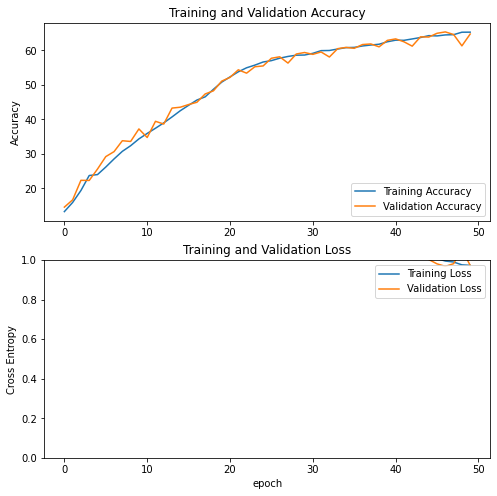

In [55]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [56]:
# Replace the paths accordingly!!

torch.save(model, 'tomato.pt')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('tomato_scripted.pth') # Save

import os 
from IPython.display import FileLink
FileLink(r'tomato_scripted.pth')

import os 
from IPython.display import FileLink
FileLink(r'tomato.pt')

/content/tomato.pt